# Final Project on Supervised Learning

### LAN and WAN Response Analysis 
- Description: The source of our data comes from the variablity of a LAN network when it is connecting to the Internet. The data is collected by the ping response time from the devices of the local internet router and to the first-hop server on the internet.
- Group Members: Eric Topmiller, Viphu Nguyen, David Gigremosa, Paul Rozario

Question to Answer: What is the worst time of day for ping response with ethernet and wireless for both LAN and WAN?

In [2]:

# Import libraries

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn import preprocessing
import matplotlib.pyplot as plt
from matplotlib import style

In [3]:
# Set the dataset from the network csv
df = pd.read_csv('ping_data.csv')
df.head()
df.sort_values('timestamp', inplace=True)

### Data Wrangling and Filtering the Data
- Done by Viphu Nguyen

In [4]:
# Finding the missing values from the ping dataset
df.isna().sum()

timestamp      0
location       0
source         0
local_dest     0
local_avg      0
remote_dest    0
remote_avg     0
dtype: int64

In [9]:
# Duplicate the dataframe in case of crashes
df1 = df.copy()

In [10]:
df1 = df1.drop(['location', 'local_dest', 'remote_dest'], axis = 1)
df1

,timestamp,source,local_avg,remote_avg
0,1559040909,wireless,4.39,9.09
1,1559040920,wireless,0.49,16.75
2,1559040930,wireless,0.56,8.31
3,1559040940,wireless,1.64,9.40
4,1559040950,wireless,1.18,9.07
...,...,...,...,...
72458,1559690659,wireless,0.83,7.85
72459,1559690670,wireless,0.84,8.88
72460,1559690680,wireless,5.73,10.92
72461,1559690690,wireless,0.19,10.00


#### *Each header definition*
- Timestamp: The current time of an event that is recorded
- Source: Network Source
- Local_avg: Response Time for local network (ms)
- Remote_avg: Response time for remote network (ms)

In [11]:
# create a column that is the start of the range of hours of the day, show the head, show it has all 24 hours of the day
#df1['hour'] = (df['timestamp'].astype(int) % 86400) / 14400
df1['hour'] = (df['timestamp'].astype(int) % 86400) / 28800
df1['hour'] = df1['hour'].astype(int)
print(df1.head())
print(df1['hour'].unique())
print(df1.info())

    timestamp    source  local_avg  remote_avg  hour
0  1559040909  wireless       4.39        9.09     1
1  1559040920  wireless       0.49       16.75     1
2  1559040930  wireless       0.56        8.31     1
3  1559040940  wireless       1.64        9.40     1
4  1559040950  wireless       1.18        9.07     1
[1 2 0]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 72463 entries, 0 to 72462
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   timestamp   72463 non-null  int64  
 1   source      72463 non-null  object 
 2   local_avg   72463 non-null  float64
 3   remote_avg  72463 non-null  float64
 4   hour        72463 non-null  int32  
dtypes: float64(2), int32(1), int64(1), object(1)
memory usage: 3.0+ MB
None


count    72463.000000
mean      1228.909344
std       3267.419743
min          0.150000
25%          0.310000
50%          0.730000
75%          2.000000
max       9999.999900
Name: local_avg, dtype: float64
count    72463.000000
mean      1238.649549
std       3263.714778
min          2.350000
25%          8.700000
50%          9.550000
75%         13.310000
max       9999.999900
Name: remote_avg, dtype: float64


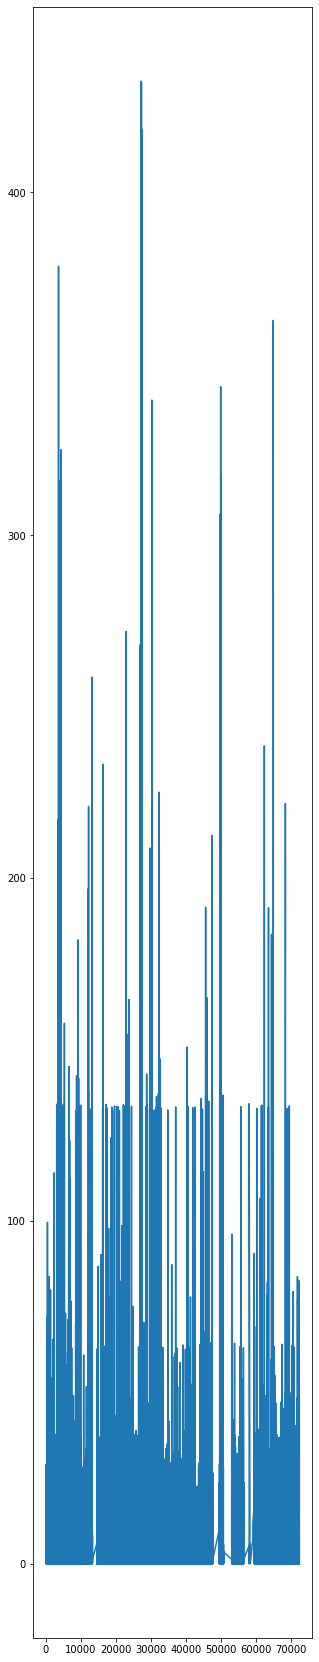

In [12]:
# remove the rows with avg of 9999.9999 since they are failures and will skew the data
#df1 = df1[(df1['local_avg'] != 9999) & (df1['remote_avg'] < 1000.0)]
df1 = df1.reset_index()
print(df1['local_avg'].describe())
print(df1['remote_avg'].describe())
# for plotting throw out the large values so we can better see the more common local_avg
df_small_local = df1[(df1['local_avg'] < 500)]
df_small_local['local_avg'].plot(figsize=(5,30))
plt.show()

In [13]:
# find the quartiles of the time data so we can create local average categorical variable
print(df1['local_avg'].describe())

count    72463.000000
mean      1228.909344
std       3267.419743
min          0.150000
25%          0.310000
50%          0.730000
75%          2.000000
max       9999.999900
Name: local_avg, dtype: float64


In [14]:
# create the categorical variable local_delay for the local delay of low, average, high using the quartiles
# we will leave in the 9999.9999 since they probably represent failures and should be placed the high
bins = [float('-inf'), 0.149, 0.15, float('inf')]
labels = ['Small', 'Medium', 'Large']
df1['local_delay'] = pd.cut(df1['local_avg'], bins=bins, labels=labels)
df1.head()
print(df1['local_delay'].unique())

['Large', 'Medium']
Categories (2, object): ['Medium' < 'Large']


In [15]:
# do a categorical variable for ismean for the local_avg because we have a lot
# of them
df1['ismean'] = 0
df1.loc[df1["local_avg"] == 0.15, "ismean"] = 1

In [16]:
# do some range categorical variables to section off the dataset based on the plot of local_avg below 500
df1['gr500'] = 0
df1.loc[df1['local_avg'] > 500.0, 'gr500'] = 1
df1['gr55'] = 0
df1.loc[(df1['local_avg'] > 55.0) & (df1['local_avg'] <= 500.0), 'gr55'] = 1
df1['gr40'] = 0
df1.loc[(df1['local_avg'] > 40.0) & (df1['local_avg'] <= 55.0), 'gr40'] = 1
df1['gr30'] = 0
df1.loc[(df1['local_avg'] > 30.0) & (df1['local_avg'] <= 40.0), 'gr30'] = 1
df1['gr20'] = 0
df1.loc[(df1['local_avg'] > 20.0) & (df1['local_avg'] <= 30.0), 'gr20'] = 1
df1['gr10'] = 0
df1.loc[(df1['local_avg'] > 10.0) & (df1['local_avg'] <= 20.0), 'gr10'] = 1
df1['gr0'] = 0
df1.loc[df1['local_avg'] <= 10.0, 'gr0'] = 1

### Data Visualizations 
- Done by Viphu Nguyen

array([[<AxesSubplot:title={'center':'local_avg'}>]], dtype=object)

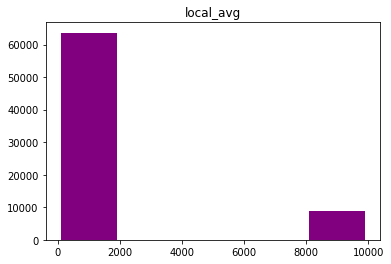

In [11]:
# Histogram for 'local_avg' response time (local) column
df1.hist(column='local_avg', bins=5, grid=False, rwidth=.9, color='purple')

Analysis: The histogram tells us that the the response time (ms) is estimated largely between 0 to 2,000 while there is a fewer amount at closer to 10,000 frequency for the response time between 8,000 to 10,000

### Use scikit-learn for Logistic Regression and DecisionTree Classification, XGBoost, Keras, Pytorch to train, test and predict a categorical variable. Use appropriate metric and interpret themeaning of the score

### Decision Tree
- Done by Viphu Nguyen

In [15]:
# Duplicate the dataframe in case of crashes
df2 = df1.copy()

In [18]:
X = df2.drop(['location', 'source', 'local_dest', 'remote_dest'], axis = 1)
y = df2['local_dest']

In [19]:
X_train, X_test, y_train, y_test= train_test_split(X, y,test_size=0.2,random_state=99)

clf = DecisionTreeClassifier(criterion='entropy', random_state=99)

In [20]:
clf.fit(X_train,y_train)
y_pred= clf.predict(X_test)
accuracy_score(y_test, y_pred)

1.0

##### Plot a Decision Tree

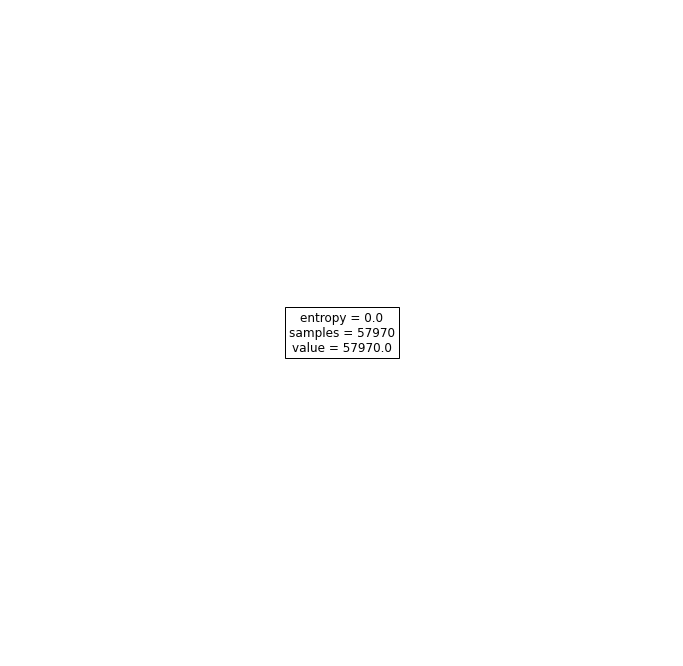

In [21]:
fig, ax = plt.subplots(figsize=(12, 12))
tree.plot_tree(decision_tree=clf, max_depth= 3,fontsize=12);